<a href="https://colab.research.google.com/github/AhmedAboulezz/Trading/blob/main/Divergence_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
  Duration:        130 bars

🔍 DIVERGENCE SIGNALS:
  Positive Divs:   0
  Negative Divs:   0
  Total Divs:      0

📈 TECHNICAL INDICATORS AT ENTRY:
  RSI (14):        34.03
  Stochastic:      20.34
  Momentum (10):   -11.33
  CCI (10):        -86.22
  MACD:            -1.6747
  MACD Signal:     -0.2637
  MACD Histogram:  -1.4109
  VWMACD:          -5.4850
  CMF (21):        0.1391
  MFI (14):        50.22

🎯 SPECIFIC DIVERGENCES DETECTED:
  No specific divergences recorded (signal from previous bar)

Trade #22 [CLOSED]

📊 PRICE INFORMATION:
  Entry Time:      2025-02-14 10:45:00-05:00
  Entry Price:     $2905.20
  Open:            $2905.20
  High:            $2906.17
  Low:             $2900.18
  Close:           $2901.76
  Exit Time:       2025-02-16 21:00:00-05:00
  Exit Price:      $2895.40
  P&L:             -0.34%
  Duration:        36 bars

🔍 DIVERGENCE SIGNALS:
  Positive Divs:   0
  Negative Divs:   0
  Total Divs:      0

📈 TE

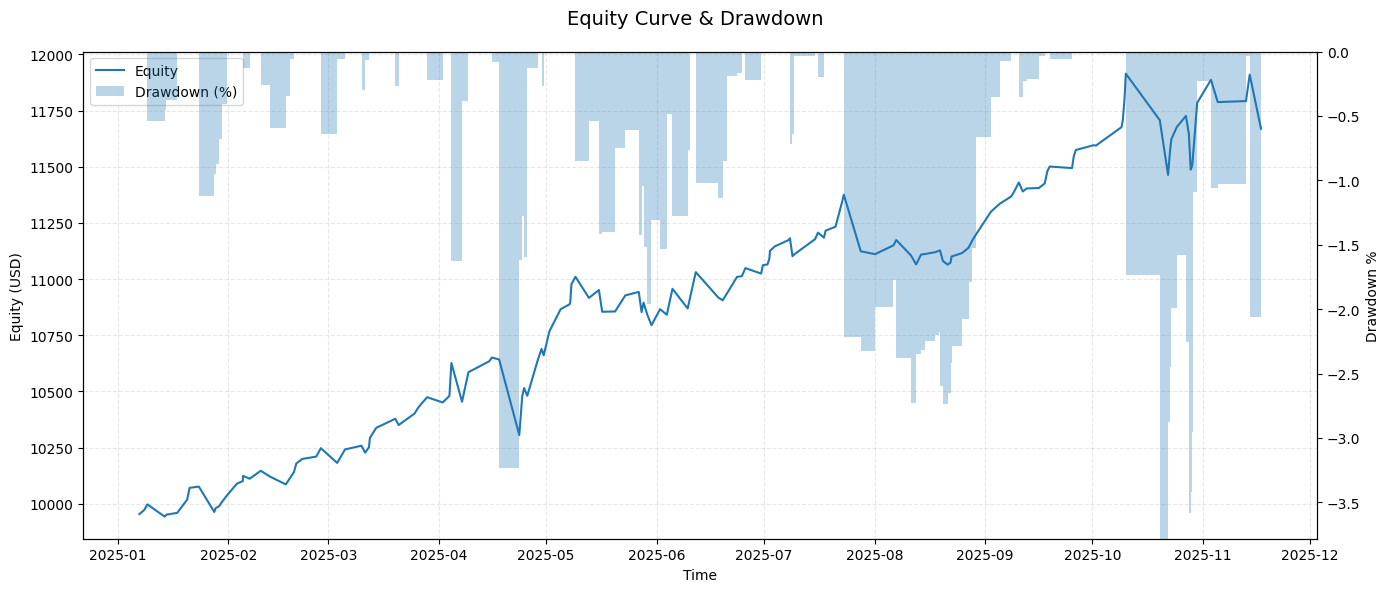

In [1]:
# Install required packages
!pip install pandas numpy matplotlib plotly scipy ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import argrelextrema
import ta
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#------------------------------------------------------------------------------
# CONFIGURATION PARAMETERS
#------------------------------------------------------------------------------

class Config:
    # Pivot settings
    prd = 5  # Pivot Period
    source = "Close"  # Source for Pivot Points: "Close" or "High/Low"

    # Divergence settings
    searchdiv = "Regular"  # "Regular", "Hidden", or "Regular/Hidden"
    showlimit = 1  # Minimum Number of Divergence (any)
    maxpp = 10  # Maximum Pivot Points to Check
    maxbars = 100  # Maximum Bars to Check
    dontconfirm = False  # Don't Wait for Confirmation

    # Quality filter
    minPosDivForEntry = 2  # Min # of Positive Divergence for Valid Long
    minNegDivForExit = 1   # Min # of Negative Divergence for Exit

    # Entry delay and drawdown
    delayBars = 0  # Delay For Entry (Bars)
    useDrawdown = False  # Use % Drawdown Before Entry
    drawdownPerc = 1.0  # Drawdown %

    # Indicator selection (all enabled by default)
    calcmacd = True
    calcmacda = True
    calcrsi = True
    calcstoc = True
    calccci = True
    calcmom = True
    calcobv = False
    calcvwmacd = True
    calccmf = True
    calcmfi = True

    # --- Indicator windows (defaults = اللي كنت حاططها في الكود) ---
    rsi_window   = 14
    macd_fast    = 12
    macd_slow    = 26
    macd_signal  = 9
    mom_window   = 10
    stoch_window = 14
    stoch_smooth = 3
    vwma_fast    = 12
    vwma_slow    = 26
    cmf_window   = 21
    cci_window   = 10
    mfi_window   = 14

    # Backtest settings
    initial_capital = 10000
    position_size = 1.0  # Use 100% of capital per trade

config = Config()

#------------------------------------------------------------------------------
# DATA LOADING
#------------------------------------------------------------------------------

def load_data_from_csv(filepath):
    """Load OHLC data from CSV file"""
    print(f"Loading data from {filepath}...")

    # Read CSV
    df = pd.read_csv(filepath)

    # Normalize column names to lowercase
    df.columns = [col.lower().strip() for col in df.columns]

    # Parse time column
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Ensure we have required columns
    required_cols = ['open', 'high', 'low', 'close']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Add volume if not present (needed for some indicators)
    if 'volume' not in df.columns:
        df['volume'] = 1000000  # Default volume
        print("Warning: No volume column found, using default values")

    print(f"Loaded {len(df)} bars from {df.index[0]} to {df.index[-1]}")
    return df

#------------------------------------------------------------------------------
# TECHNICAL INDICATORS
#------------------------------------------------------------------------------

def calculate_indicators(df):
    df = df.copy()

    close = df["close"].astype(float)
    high  = df["high"].astype(float)
    low   = df["low"].astype(float)
    vol   = df["volume"].astype(float)

    # windows من config
    rsi_w        = config.rsi_window
    macd_fast    = config.macd_fast
    macd_slow    = config.macd_slow
    macd_signal  = config.macd_signal
    mom_w        = config.mom_window
    stoch_w      = config.stoch_window
    stoch_smooth = config.stoch_smooth
    vwma_fast_w  = config.vwma_fast
    vwma_slow_w  = config.vwma_slow
    cmf_w        = config.cmf_window
    cci_w        = config.cci_window
    mfi_w        = config.mfi_window

    import ta

    # RSI
    df["rsi"] = ta.momentum.RSIIndicator(
        close=close, window=rsi_w
    ).rsi()

    # MACD
    macd_ind = ta.trend.MACD(
        close=close,
        window_slow=macd_slow,
        window_fast=macd_fast,
        window_sign=macd_signal
    )
    df["macd"]        = macd_ind.macd()
    df["macd_signal"] = macd_ind.macd_signal()
    df["macd_hist"]   = macd_ind.macd_diff()

    # Momentum
    df["momentum"] = close - close.shift(mom_w)

    # Stochastic
    lowest_low   = low.rolling(window=stoch_w, min_periods=stoch_w).min()
    highest_high = high.rolling(window=stoch_w, min_periods=stoch_w).max()
    stoch_k = 100.0 * (close - lowest_low) / (highest_high - lowest_low)
    df["stoch"] = stoch_k.rolling(
        window=stoch_smooth,
        min_periods=stoch_smooth
    ).mean()

    # VW-MACD (VWMA fast - VWMA slow)
    vwma_fast = (close * vol).rolling(vwma_fast_w).sum() / vol.rolling(vwma_fast_w).sum()
    vwma_slow = (close * vol).rolling(vwma_slow_w).sum() / vol.rolling(vwma_slow_w).sum()
    df["vwmacd"] = vwma_fast - vwma_slow

    # CMF
    df["cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
        high=high, low=low, close=close, volume=vol, window=cmf_w
    ).chaikin_money_flow()

    # CCI على close
    sma_close = close.rolling(cci_w, min_periods=cci_w).mean()
    mad_close = close.rolling(cci_w, min_periods=cci_w).apply(
        lambda x: np.mean(np.abs(x - x.mean())),
        raw=True
    )
    df["cci"] = (close - sma_close) / (0.015 * mad_close)

    # MFI
    price = close
    raw_mf = price * vol
    pos_mf = [0.0]
    neg_mf = [0.0]

    for i in range(1, len(df)):
        if price.iloc[i] > price.iloc[i - 1]:
            pos_mf.append(raw_mf.iloc[i])
            neg_mf.append(0.0)
        elif price.iloc[i] < price.iloc[i - 1]:
            pos_mf.append(0.0)
            neg_mf.append(raw_mf.iloc[i])
        else:
            pos_mf.append(0.0)
            neg_mf.append(0.0)

    pos_mf = pd.Series(pos_mf, index=df.index)
    neg_mf = pd.Series(neg_mf, index=df.index)

    pos_roll = pos_mf.rolling(mfi_w, min_periods=mfi_w).sum()
    neg_roll = neg_mf.rolling(mfi_w, min_periods=mfi_w).sum()

    mfi = 100.0 * (pos_roll / (pos_roll + neg_roll))
    df["mfi"] = mfi

    # OBV
    obv_values = [0.0]
    for i in range(1, len(df)):
        if close.iloc[i] > close.iloc[i-1]:
            obv_values.append(obv_values[-1] + vol.iloc[i])
        elif close.iloc[i] < close.iloc[i-1]:
            obv_values.append(obv_values[-1] - vol.iloc[i])
        else:
            obv_values.append(obv_values[-1])
    df['obv'] = obv_values

    df = df.fillna(method='bfill').fillna(method='ffill')

    return df



#------------------------------------------------------------------------------
# PIVOT POINT DETECTION
#------------------------------------------------------------------------------

def find_pivots(df, period):
    """Find pivot highs and pivot lows"""
    print(f"Finding pivot points with period {period}...")

    if config.source == "Close":
        high_series = df['close']
        low_series = df['close']
    else:
        high_series = df['high']
        low_series = df['low']

    # Initialize pivot columns
    df['pivot_high'] = np.nan
    df['pivot_high_bar'] = np.nan
    df['pivot_low'] = np.nan
    df['pivot_low_bar'] = np.nan

    for i in range(period, len(df) - period):
        # Check pivot high
        is_pivot_high = True
        for j in range(1, period + 1):
            if high_series.iloc[i] <= high_series.iloc[i - j] or \
               high_series.iloc[i] <= high_series.iloc[i + j]:
                is_pivot_high = False
                break

        if is_pivot_high:
            df.iloc[i, df.columns.get_loc('pivot_high')] = high_series.iloc[i]
            df.iloc[i, df.columns.get_loc('pivot_high_bar')] = i

        # Check pivot low
        is_pivot_low = True
        for j in range(1, period + 1):
            if low_series.iloc[i] >= low_series.iloc[i - j] or \
               low_series.iloc[i] >= low_series.iloc[i + j]:
                is_pivot_low = False
                break

        if is_pivot_low:
            df.iloc[i, df.columns.get_loc('pivot_low')] = low_series.iloc[i]
            df.iloc[i, df.columns.get_loc('pivot_low_bar')] = i

    num_highs = df['pivot_high'].notna().sum()
    num_lows = df['pivot_low'].notna().sum()
    print(f"Found {num_highs} pivot highs and {num_lows} pivot lows")

    return df

#------------------------------------------------------------------------------
# DIVERGENCE DETECTION
#------------------------------------------------------------------------------

def detect_divergence(df, indicator_name, bar_idx, pivot_positions, pivot_values,
                     is_bullish, is_regular):
    """
    Detect divergence at a specific bar
    Returns: length of divergence if found, else 0
    """

    if bar_idx < config.prd:
        return 0

    startpoint = 0 if config.dontconfirm else 1

    if config.source == "Close":
        price_series = df['close'].values
    else:
        price_series = df['low'].values if is_bullish else df['high'].values

    indicator_series = df[indicator_name].values

    # Check confirmation condition
    if not config.dontconfirm:
        if is_bullish:
            if not (indicator_series[bar_idx] > indicator_series[bar_idx - 1] or
                   df['close'].values[bar_idx] > df['close'].values[bar_idx - 1]):
                return 0
        else:
            if not (indicator_series[bar_idx] < indicator_series[bar_idx - 1] or
                   df['close'].values[bar_idx] < df['close'].values[bar_idx - 1]):
                return 0

    # Check each pivot
    for pivot_idx in range(min(config.maxpp, len(pivot_positions))):
        if pivot_idx >= len(pivot_positions) or np.isnan(pivot_positions[pivot_idx]):
            break

        pivot_bar = int(pivot_positions[pivot_idx])
        length = bar_idx - pivot_bar

        if length > config.maxbars:
            break

        if length > 5:
            # Check divergence conditions
            if is_bullish and is_regular:
                # Positive Regular: indicator makes higher low, price makes lower low
                div_condition = (indicator_series[bar_idx - startpoint] > indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] < pivot_values[pivot_idx])
            elif is_bullish and not is_regular:
                # Positive Hidden: indicator makes lower low, price makes higher low
                div_condition = (indicator_series[bar_idx - startpoint] < indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] > pivot_values[pivot_idx])
            elif not is_bullish and is_regular:
                # Negative Regular: indicator makes lower high, price makes higher high
                div_condition = (indicator_series[bar_idx - startpoint] < indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] > pivot_values[pivot_idx])
            else:
                # Negative Hidden: indicator makes higher high, price makes lower high
                div_condition = (indicator_series[bar_idx - startpoint] > indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] < pivot_values[pivot_idx])

            if div_condition:
                # Check if line is valid (no crossings)
                slope1 = (indicator_series[bar_idx - startpoint] - indicator_series[pivot_bar]) / length
                slope2 = (df['close'].values[bar_idx - startpoint] - df['close'].values[pivot_bar]) / length

                virtual_line1 = indicator_series[bar_idx - startpoint]
                virtual_line2 = df['close'].values[bar_idx - startpoint]

                valid = True
                for y in range(1 + startpoint, length):
                    virtual_line1 -= slope1
                    virtual_line2 -= slope2

                    check_idx = bar_idx - y
                    if is_bullish:
                        if indicator_series[check_idx] < virtual_line1 or \
                           df['close'].values[check_idx] < virtual_line2:
                            valid = False
                            break
                    else:
                        if indicator_series[check_idx] > virtual_line1 or \
                           df['close'].values[check_idx] > virtual_line2:
                            valid = False
                            break

                if valid:
                    return length

    return 0

from collections import deque
import numpy as np

def scan_all_divergences(df):
    """Scan for all divergences across all indicators (optimized arrays)"""
    print("Scanning for divergences...")

    n = len(df)

    # 1) جهّز قائمة المؤشرات اللي بنشتغل عليها (زي ما هي)
    indicators_to_check = []
    if config.calcmacd:
        indicators_to_check.append('macd')
    if config.calcmacda:
        indicators_to_check.append('macd_hist')
    if config.calcrsi:
        indicators_to_check.append('rsi')
    if config.calcstoc:
        indicators_to_check.append('stoch')
    if config.calccci:
        indicators_to_check.append('cci')
    if config.calcmom:
        indicators_to_check.append('momentum')
    if config.calcobv:
        indicators_to_check.append('obv')
    if config.calcvwmacd:
        indicators_to_check.append('vwmacd')
    if config.calccmf:
        indicators_to_check.append('cmf')
    if config.calcmfi:
        indicators_to_check.append('mfi')

    # 2) حضّر أعمدة الديفرجنس في Arrays بدل DataFrame مباشر
    div_cols = []
    div_arrays = {}
    for ind in indicators_to_check:
        for div_type in ['pos_reg', 'neg_reg', 'pos_hid', 'neg_hid']:
            col_name = f'{ind}_{div_type}'
            div_cols.append(col_name)
            div_arrays[col_name] = np.zeros(n, dtype=np.int32)

    # 3) حوّل الـ series المهمة إلى Arrays مرّة واحدة
    close_arr = df['close'].values.astype(float)
    low_arr   = df['low'].values.astype(float)
    high_arr  = df['high'].values.astype(float)

    ind_arrays = {
        ind: df[ind].values.astype(float)
        for ind in indicators_to_check
    }

    # 4) Arrays للـ pivots عشان نستخدمها مع deque
    pivot_high_vals_all = df['pivot_high'].values.astype(float)
    pivot_low_vals_all  = df['pivot_low'].values.astype(float)

    recent_high_bars = deque()
    recent_high_vals = deque()
    recent_low_bars  = deque()
    recent_low_vals  = deque()

    # ------------------------------------------------------------------
    # 👇 Helper داخلي: نفس detect_divergence بس شغال على Arrays
    # ------------------------------------------------------------------
    def detect_with_arrays(indicator_series, bar_idx,
                           pivot_positions, pivot_values,
                           is_bullish, is_regular):
        """نفس منطق detect_divergence بالظبط لكن باستخدام arrays فقط"""
        if bar_idx < config.prd:
            return 0

        dontconfirm = config.dontconfirm
        startpoint = 0 if dontconfirm else 1

        # اختيار الـ price series بناءً على الـ source
        if config.source == "Close":
            price_series = close_arr
        else:
            price_series = low_arr if is_bullish else high_arr

        # شرط الـ confirmation زي ما هو
        if not dontconfirm:
            if is_bullish:
                if not (
                    indicator_series[bar_idx] > indicator_series[bar_idx - 1] or
                    close_arr[bar_idx] > close_arr[bar_idx - 1]
                ):
                    return 0
            else:
                if not (
                    indicator_series[bar_idx] < indicator_series[bar_idx - 1] or
                    close_arr[bar_idx] < close_arr[bar_idx - 1]
                ):
                    return 0

        maxpp = config.maxpp
        maxbars = config.maxbars

        m = len(pivot_positions)

        # لوب على الـ pivots (نفس الفكرة)
        for pivot_idx in range(min(maxpp, m)):
            pivot_bar = pivot_positions[pivot_idx]
            length = bar_idx - pivot_bar

            if length > maxbars:
                break
            if length <= 5:
                continue

            pivot_price = pivot_values[pivot_idx]

            ind_curr   = indicator_series[bar_idx - startpoint]
            ind_pivot  = indicator_series[pivot_bar]
            price_curr = price_series[bar_idx - startpoint]

            # نفس شروط الديفرجنس بالظبط
            if is_bullish and is_regular:
                # Positive Regular
                div_condition = (
                    ind_curr > ind_pivot and
                    price_curr < pivot_price
                )
            elif is_bullish and not is_regular:
                # Positive Hidden
                div_condition = (
                    ind_curr < ind_pivot and
                    price_curr > pivot_price
                )
            elif (not is_bullish) and is_regular:
                # Negative Regular
                div_condition = (
                    ind_curr < ind_pivot and
                    price_curr > pivot_price
                )
            else:
                # Negative Hidden
                div_condition = (
                    ind_curr > ind_pivot and
                    price_curr < pivot_price
                )

            if not div_condition:
                continue

            # خطّين الـ virtual line – نفس الكود القديم
            slope1 = (ind_curr - ind_pivot) / length
            slope2 = (close_arr[bar_idx - startpoint] - close_arr[pivot_bar]) / length

            virtual_line1 = ind_curr
            virtual_line2 = close_arr[bar_idx - startpoint]

            valid = True
            for y in range(1 + startpoint, length):
                virtual_line1 -= slope1
                virtual_line2 -= slope2
                check_idx = bar_idx - y

                if is_bullish:
                    if (indicator_series[check_idx] < virtual_line1 or
                        close_arr[check_idx] < virtual_line2):
                        valid = False
                        break
                else:
                    if (indicator_series[check_idx] > virtual_line1 or
                        close_arr[check_idx] > virtual_line2):
                        valid = False
                        break

            if valid:
                return length

        return 0

    # ------------------------------------------------------------------
    # 5) اللوب الرئيسي على البارات + استخدام deque للـ pivots
    # ------------------------------------------------------------------
    for i in range(n):
        prev = i - 1
        if prev >= 0:
            ph = pivot_high_vals_all[prev]
            if not np.isnan(ph):
                recent_high_bars.appendleft(prev)
                recent_high_vals.appendleft(ph)

            pl = pivot_low_vals_all[prev]
            if not np.isnan(pl):
                recent_low_bars.appendleft(prev)
                recent_low_vals.appendleft(pl)

        # شيل أي pivots قديمة أقدم من maxbars
        cutoff = i - config.maxbars
        while recent_high_bars and recent_high_bars[-1] < cutoff:
            recent_high_bars.pop()
            recent_high_vals.pop()
        while recent_low_bars and recent_low_bars[-1] < cutoff:
            recent_low_bars.pop()
            recent_low_vals.pop()

        if i < config.prd + 10:
            continue

        pivot_high_bars = list(recent_high_bars)
        pivot_high_vals = list(recent_high_vals)
        pivot_low_bars  = list(recent_low_bars)
        pivot_low_vals  = list(recent_low_vals)

        has_highs = len(pivot_high_bars) > 0
        has_lows  = len(pivot_low_bars) > 0

        # 6) لوب على المؤشرات – بس على الـ arrays
        for ind in indicators_to_check:
            ind_arr = ind_arrays[ind]

            if np.isnan(ind_arr[i]):
                continue

            # Positive Regular
            if config.searchdiv in ["Regular", "Regular/Hidden"] and has_lows:
                div_len = detect_with_arrays(
                    ind_arr, i,
                    pivot_low_bars, pivot_low_vals,
                    is_bullish=True, is_regular=True
                )
                if div_len > 0:
                    div_arrays[f'{ind}_pos_reg'][i] = div_len

            # Negative Regular
            if config.searchdiv in ["Regular", "Regular/Hidden"] and has_highs:
                div_len = detect_with_arrays(
                    ind_arr, i,
                    pivot_high_bars, pivot_high_vals,
                    is_bullish=False, is_regular=True
                )
                if div_len > 0:
                    div_arrays[f'{ind}_neg_reg'][i] = div_len

            # Positive Hidden
            if config.searchdiv in ["Hidden", "Regular/Hidden"] and has_lows:
                div_len = detect_with_arrays(
                    ind_arr, i,
                    pivot_low_bars, pivot_low_vals,
                    is_bullish=True, is_regular=False
                )
                if div_len > 0:
                    div_arrays[f'{ind}_pos_hid'][i] = div_len

            # Negative Hidden
            if config.searchdiv in ["Hidden", "Regular/Hidden"] and has_highs:
                div_len = detect_with_arrays(
                    ind_arr, i,
                    pivot_high_bars, pivot_high_vals,
                    is_bullish=False, is_regular=False
                )
                if div_len > 0:
                    div_arrays[f'{ind}_neg_hid'][i] = div_len

    # 7) ارجع النتايج للـ DataFrame زي ما كانت
    for col_name in div_cols:
        df[col_name] = div_arrays[col_name]

    # Count total divergences
    df['total_divergences'] = 0
    for col in div_cols:
        df['total_divergences'] += (df[col] > 0).astype(int)

    # Filter by minimum divergences
    df.loc[df['total_divergences'] < config.showlimit, div_cols] = 0

    # Count positive and negative divergences
    df['pos_div_count'] = 0
    df['neg_div_count'] = 0
    for col in div_cols:
        if 'pos_' in col:
            df['pos_div_count'] += (df[col] > 0).astype(int)
        else:
            df['neg_div_count'] += (df[col] > 0).astype(int)

    total_divs = (df['total_divergences'] > 0).sum()
    print(f"Found {total_divs} bars with divergences")

    return df


#------------------------------------------------------------------------------
# TRADING STRATEGY
#------------------------------------------------------------------------------

def run_strategy(df):
    """Execute trading strategy based on divergences"""
    print("Running strategy...")

    df['signal'] = 0
    df['position'] = 0
    df['entry_price'] = np.nan
    df['exit_price'] = np.nan

    buy_signal_bar = None
    buy_signal_price = None
    sell_signal_bar = None  # ✅ Track when we get exit signal
    in_position = False

    for i in range(len(df)):
        # Check for entry signal (positive divergences >= threshold)
        if not in_position and df['pos_div_count'].iloc[i] >= config.minPosDivForEntry:
            buy_signal_bar = i
            buy_signal_price = df['close'].iloc[i]

        # Process entry after delay
        if buy_signal_bar is not None and not in_position:
            bars_since_signal = i - buy_signal_bar

            # Need at least 1 bar delay to enter at next bar's open
            if bars_since_signal >= max(1, config.delayBars):
                enter_trade = True

                if config.useDrawdown:
                    cur_drawdown = (buy_signal_price - df['close'].iloc[i-1]) / buy_signal_price * 100.0
                    if cur_drawdown < config.drawdownPerc:
                        enter_trade = False

                if enter_trade:
                    df.loc[df.index[i], 'signal'] = 1
                    df.loc[df.index[i], 'entry_price'] = df['open'].iloc[i]  # Next bar's open
                    in_position = True
                    buy_signal_bar = None
                    buy_signal_price = None

        # Set position status
        if in_position:
            df.loc[df.index[i], 'position'] = 1

        # ✅ Check for exit signal (negative divergences >= threshold)
        if in_position and df['neg_div_count'].iloc[i] >= config.minNegDivForExit:
            sell_signal_bar = i  # Mark the signal bar

        # ✅ Process exit at NEXT bar's open (just like entry)
        if sell_signal_bar is not None and in_position:
            bars_since_exit_signal = i - sell_signal_bar

            # Exit at next bar's open (1 bar delay)
            if bars_since_exit_signal >= 1:
                df.loc[df.index[i], 'signal'] = -1
                df.loc[df.index[i], 'exit_price'] = df['open'].iloc[i]  # Next bar's open
                in_position = False
                sell_signal_bar = None

    return df

#------------------------------------------------------------------------------
# VISUALIZATION
#------------------------------------------------------------------------------

def plot_candlestick_with_signals(df):
    """Create interactive candlestick chart with entry/exit signals"""
    print("Creating candlestick chart...")

    # Create figure with subplots
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        subplot_titles=('Price with Entry/Exit Signals', 'Divergence Counts'),
        row_heights=[0.7, 0.3]
    )

    # Add candlestick
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            name='Price',
            increasing_line_color='green',
            decreasing_line_color='red'
        ),
        row=1, col=1
    )

    # Add entry signals (buy)
    entries = df[df['signal'] == 1]
    if len(entries) > 0:
        fig.add_trace(
            go.Scatter(
                x=entries.index,
                y=entries['entry_price'],
                mode='markers',
                name='BUY',
                marker=dict(
                    symbol='triangle-up',
                    size=15,
                    color='lime',
                    line=dict(color='darkgreen', width=2)
                )
            ),
            row=1, col=1
        )

    # Add exit signals (sell)
    exits = df[df['signal'] == -1]
    if len(exits) > 0:
        fig.add_trace(
            go.Scatter(
                x=exits.index,
                y=exits['exit_price'],
                mode='markers',
                name='SELL',
                marker=dict(
                    symbol='triangle-down',
                    size=15,
                    color='red',
                    line=dict(color='darkred', width=2)
                )
            ),
            row=1, col=1
        )

    # Add positive divergence count
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['pos_div_count'],
            mode='lines',
            name='Positive Divergences',
            line=dict(color='green', width=1),
            fill='tozeroy'
        ),
        row=2, col=1
    )

    # Add negative divergence count
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['neg_div_count'],
            mode='lines',
            name='Negative Divergences',
            line=dict(color='red', width=1),
            fill='tozeroy'
        ),
        row=2, col=1
    )

    # Add threshold lines
    fig.add_hline(
        y=config.minPosDivForEntry,
        line_dash="dash",
        line_color="green",
        annotation_text=f"Entry Threshold ({config.minPosDivForEntry})",
        row=2, col=1
    )

    fig.add_hline(
        y=config.minNegDivForExit,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Exit Threshold ({config.minNegDivForExit})",
        row=2, col=1
    )

    # Update layout
    fig.update_layout(
        title='Divergence-Based Trading Strategy',
        xaxis_title='Time',
        yaxis_title='Price',
        xaxis2_title='Time',
        yaxis2_title='Divergence Count',
        height=900,
        showlegend=True,
        xaxis_rangeslider_visible=False
    )

    fig.show()
    print("Chart displayed successfully")

#------------------------------------------------------------------------------
# PERFORMANCE METRICS
#------------------------------------------------------------------------------

def calculate_performance(df):
    """Calculate and display performance metrics + final overview block"""
    print("\n" + "="*60)
    print("PERFORMANCE METRICS")
    print("="*60)

    entries = df[df['signal'] == 1].copy()
    exits   = df[df['signal'] == -1].copy()

    if len(entries) == 0:
        print("No trades were executed")
        return

    # Match entries with exits
    trades = []
    for i, entry_row in entries.iterrows():
        entry_idx   = df.index.get_loc(i)
        entry_price = entry_row['entry_price']

        # Find next exit
        exit_found = False
        for j, exit_row in exits.iterrows():
            exit_idx = df.index.get_loc(j)
            if exit_idx > entry_idx:
                exit_price = exit_row['exit_price']
                pnl_pct    = (exit_price - entry_price) / entry_price * 100
                trades.append({
                    'entry_time': i,
                    'exit_time': j,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'bars_held': exit_idx - entry_idx,
                    'entry_idx': entry_idx
                })
                exit_found = True
                break

        if not exit_found:
            # Still in trade → mark to last close
            trades.append({
                'entry_time': i,
                'exit_time': None,
                'entry_price': entry_price,
                'exit_price': df['close'].iloc[-1],
                'pnl_pct': (df['close'].iloc[-1] - entry_price) / entry_price * 100,
                'bars_held': len(df) - entry_idx - 1,
                'entry_idx': entry_idx
            })

    trades_df = pd.DataFrame(trades)

    # =========================
    # 1) Basic trade statistics
    # =========================
    total_trades    = len(trades_df)
    winning_trades  = len(trades_df[trades_df['pnl_pct'] > 0])
    losing_trades   = len(trades_df[trades_df['pnl_pct'] < 0])
    win_rate        = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    avg_win         = trades_df[trades_df['pnl_pct'] > 0]['pnl_pct'].mean() if winning_trades > 0 else 0
    avg_loss        = trades_df[trades_df['pnl_pct'] < 0]['pnl_pct'].mean() if losing_trades > 0 else 0
    avg_pnl         = trades_df['pnl_pct'].mean()
    total_return_pct = trades_df['pnl_pct'].sum()
    avg_bars_held   = trades_df['bars_held'].mean()

    # =========================
    # 2) Equity curve + DD + PF
    # =========================
    initial_capital = config.initial_capital
    position_size   = config.position_size  # fraction of equity per trade

    equity        = initial_capital
    equity_curve  = []
    gross_profit  = 0.0
    gross_loss    = 0.0

    # تأكد إن الصفقات بالترتيب الزمني
    trades_df = trades_df.sort_values(by="entry_time")

    for _, row in trades_df.iterrows():
        r = (row['pnl_pct'] / 100.0) * position_size
        trade_pnl_usd = equity * r
        equity += trade_pnl_usd
        equity_curve.append(equity)

        if trade_pnl_usd > 0:
            gross_profit += trade_pnl_usd
        elif trade_pnl_usd < 0:
            gross_loss += -trade_pnl_usd  # positive value

    total_pnl_usd   = equity - initial_capital
    total_pnl_pct   = (equity / initial_capital - 1.0) * 100.0

    # =========================
    # 2-bis) Equity series + Drawdown series
    # =========================

    # نربط كل نقطة في equity_curve بزمن (نستخدم exit_time أو آخر بار لو الصفقة لسه مفتوحة)
    equity_timestamps = []
    for _, row in trades_df.iterrows():
        if row["exit_time"] is not None:
            equity_timestamps.append(row["exit_time"])
        else:
            # صفقة مفتوحة → نربطها بآخر شمعة
            equity_timestamps.append(df.index[-1])

    equity_series = pd.Series(
        equity_curve,
        index=pd.to_datetime(equity_timestamps, utc=True)
    )
    # نشيل الـ timezone ونرتّب
    equity_series.index = equity_series.index.tz_localize(None)
    equity_series = equity_series.sort_index()


    # Drawdown % من الـ equity curve
    peak_equity = equity_series.cummax()
    dd_series = (equity_series - peak_equity) / peak_equity * 100.0  # قيم سالبة أو صفر

    # Max equity drawdown من الـ series
    max_dd_pct = dd_series.min()  # ده رقم سالب (مثلاً -12%)
    max_dd_usd = peak_equity[dd_series.idxmin()] - equity_series[dd_series.idxmin()]

    # نكمّل حسابات الـ P&L زي ما هي
    total_pnl_usd   = equity - initial_capital
    total_pnl_pct   = (equity / initial_capital - 1.0) * 100.0


    # Profit factor
    if gross_loss > 1e-9:
        profit_factor = gross_profit / gross_loss
    else:
        profit_factor = float('inf')

    # =========================
    # 3) نفس البلوك القديم لو حابب
    # =========================
    print(f"Total Trades:       {total_trades}")
    print(f"Winning Trades:     {winning_trades}")
    print(f"Losing Trades:      {losing_trades}")
    print(f"Win Rate:           {win_rate:.2f}%")
    print(f"Average Win:        {avg_win:.2f}%")
    print(f"Average Loss:       {avg_loss:.2f}%")
    print(f"Average P&L:        {avg_pnl:.2f}%")
    print(f"Total Return (sum%):{total_return_pct:.2f}%")
    print(f"Avg Bars Held:      {avg_bars_held:.1f}")
    print("\n" + "="*60)

    # =========================
    # 4) Detailed trade breakdown (زي ما هو)
    # =========================
    print("\nDETAILED TRADE ANALYSIS WITH INDICATORS:")
    print("="*60)

    for idx, trade in trades_df.iterrows():
        status    = "CLOSED" if trade['exit_time'] is not None else "OPEN"
        entry_idx = trade['entry_idx']

        print(f"\n{'='*60}")
        print(f"Trade #{idx+1} [{status}]")
        print(f"{'='*60}")

        # Price information
        print(f"\n📊 PRICE INFORMATION:")
        print(f"  Entry Time:      {trade['entry_time']}")
        print(f"  Entry Price:     ${trade['entry_price']:.2f}")
        print(f"  Open:            ${df['open'].iloc[entry_idx]:.2f}")
        print(f"  High:            ${df['high'].iloc[entry_idx]:.2f}")
        print(f"  Low:             ${df['low'].iloc[entry_idx]:.2f}")
        print(f"  Close:           ${df['close'].iloc[entry_idx]:.2f}")

        if trade['exit_time'] is not None:
            print(f"  Exit Time:       {trade['exit_time']}")
            print(f"  Exit Price:      ${trade['exit_price']:.2f}")
        else:
            print(f"  Current Price:   ${trade['exit_price']:.2f}")

        print(f"  P&L:             {trade['pnl_pct']:+.2f}%")
        print(f"  Duration:        {int(trade['bars_held'])} bars")

        # Divergence counts
        print(f"\n🔍 DIVERGENCE SIGNALS:")
        print(f"  Positive Divs:   {int(df['pos_div_count'].iloc[entry_idx])}")
        print(f"  Negative Divs:   {int(df['neg_div_count'].iloc[entry_idx])}")
        print(f"  Total Divs:      {int(df['total_divergences'].iloc[entry_idx])}")

        # Technical indicators
        print(f"\n📈 TECHNICAL INDICATORS AT ENTRY:")
        if config.calcrsi:
            print(f"  RSI (14):        {df['rsi'].iloc[entry_idx]:.2f}")
        if config.calcstoc:
            print(f"  Stochastic:      {df['stoch'].iloc[entry_idx]:.2f}")
        if config.calcmom:
            print(f"  Momentum (10):   {df['momentum'].iloc[entry_idx]:.2f}")
        if config.calccci:
            print(f"  CCI (10):        {df['cci'].iloc[entry_idx]:.2f}")
        if config.calcmacd:
            print(f"  MACD:            {df['macd'].iloc[entry_idx]:.4f}")
            print(f"  MACD Signal:     {df['macd_signal'].iloc[entry_idx]:.4f}")
        if config.calcmacda:
            print(f"  MACD Histogram:  {df['macd_hist'].iloc[entry_idx]:.4f}")
        if config.calcobv:
            print(f"  OBV:             {df['obv'].iloc[entry_idx]:,.0f}")
        if config.calcvwmacd:
            print(f"  VWMACD:          {df['vwmacd'].iloc[entry_idx]:.4f}")
        if config.calccmf:
            print(f"  CMF (21):        {df['cmf'].iloc[entry_idx]:.4f}")
        if config.calcmfi:
            print(f"  MFI (14):        {df['mfi'].iloc[entry_idx]:.2f}")

        print(f"\n🎯 SPECIFIC DIVERGENCES DETECTED:")
        divergence_found = False
        indicators_list  = []
        if config.calcmacd:
            indicators_list.append(('MACD', 'macd'))
        if config.calcmacda:
            indicators_list.append(('MACD Hist', 'macd_hist'))
        if config.calcrsi:
            indicators_list.append(('RSI', 'rsi'))
        if config.calcstoc:
            indicators_list.append(('Stochastic', 'stoch'))
        if config.calccci:
            indicators_list.append(('CCI', 'cci'))
        if config.calcmom:
            indicators_list.append(('Momentum', 'momentum'))
        if config.calcobv:
            indicators_list.append(('OBV', 'obv'))
        if config.calcvwmacd:
            indicators_list.append(('VWMACD', 'vwmacd'))
        if config.calccmf:
            indicators_list.append(('CMF', 'cmf'))
        if config.calcmfi:
            indicators_list.append(('MFI', 'mfi'))

        for ind_name, ind_col in indicators_list:
            divs = []
            if f'{ind_col}_pos_reg' in df.columns and df[f'{ind_col}_pos_reg'].iloc[entry_idx] > 0:
                divs.append(f"Pos Regular ({int(df[f'{ind_col}_pos_reg'].iloc[entry_idx])} bars)")
                divergence_found = True
            if f'{ind_col}_neg_reg' in df.columns and df[f'{ind_col}_neg_reg'].iloc[entry_idx] > 0:
                divs.append(f"Neg Regular ({int(df[f'{ind_col}_neg_reg'].iloc[entry_idx])} bars)")
                divergence_found = True
            if f'{ind_col}_pos_hid' in df.columns and df[f'{ind_col}_pos_hid'].iloc[entry_idx] > 0:
                divs.append(f"Pos Hidden ({int(df[f'{ind_col}_pos_hid'].iloc[entry_idx])} bars)")
                divergence_found = True
            if f'{ind_col}_neg_hid' in df.columns and df[f'{ind_col}_neg_hid'].iloc[entry_idx] > 0:
                divs.append(f"Neg Hidden ({int(df[f'{ind_col}_neg_hid'].iloc[entry_idx])} bars)")
                divergence_found = True

            if divs:
                print(f"  {ind_name:15s}: {', '.join(divs)}")

        if not divergence_found:
            print(f"  No specific divergences recorded (signal from previous bar)")

    # =========================
    # 5) FINAL OVERVIEW BLOCK
    # =========================
    print("\n" + "="*60)
    print("OVERVIEW (TradingView-style)")
    print("="*60)
    print(f"Total P&L        : {total_pnl_usd:+.2f} USD ({total_pnl_pct:+.2f}%)")
    print(f"Max equity DD    : {max_dd_usd:.2f} USD ({max_dd_pct:.2f}%)")
    print(f"Total trades     : {total_trades}")
    print(f"Profitable trades: {winning_trades}/{total_trades} ({win_rate:.2f}%)")
    print(f"Profit factor    : {profit_factor:.3f}")
    print("="*60)
    print("\nShowing equity + drawdown chart ...")
    plot_equity_and_drawdown(equity_series, dd_series)
    plot_equity_and_drawdown_interactive(equity_series, dd_series)

def plot_equity_and_drawdown_interactive(equity_series, dd_series):
    """
    يرسم:
      - خط الـ Equity بمرور الوقت (interactive)
      - Area chart للـ Drawdown % تحتها (interactive برضه)
    """
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3],
        subplot_titles=("Equity Curve", "Drawdown %")
    )

    # --- Equity Curve (فوق) ---
    fig.add_trace(
        go.Scatter(
            x=equity_series.index,
            y=equity_series.values,
            mode="lines",
            name="Equity"
        ),
        row=1, col=1
    )

    # --- Drawdown % (تحت) ---
    fig.add_trace(
        go.Scatter(
            x=dd_series.index,
            y=dd_series.values,
            mode="lines",
            name="Drawdown %",
            fill="tozeroy"   # يملأ لحد 0 (هتشوفها تحت الصفر)
        ),
        row=2, col=1
    )

    # محاور
    fig.update_yaxes(title_text="Equity (USD)", row=1, col=1)
    fig.update_yaxes(title_text="Drawdown %", row=2, col=1)

    # نضمن إن الـ DD ظاهر تحت 0
    min_dd = float(min(dd_series.min(), -0.1))
    fig.update_yaxes(range=[min_dd, 0], row=2, col=1)

    # Layout عام
    fig.update_layout(
        title="Equity Curve & Drawdown (Interactive)",
        showlegend=True,
        height=800,
        xaxis2_rangeslider_visible=False
    )

    fig.show()


def plot_equity_and_drawdown(equity_series, dd_series):
    """
    يرسم:
      - خط الـ Equity بمرور الوقت
      - Area تحت الصفر للـ Drawdown %
    """
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # خط الـ Equity
    ax1.plot(
        equity_series.index,
        equity_series.values,
        label="Equity",
        linewidth=1.5
    )
    ax1.set_ylabel("Equity (USD)")
    ax1.set_xlabel("Time")
    ax1.grid(True, which="both", linestyle="--", alpha=0.3)

    # محور تاني للـ Drawdown (%)
    ax2 = ax1.twinx()
    ax2.fill_between(
        dd_series.index,
        dd_series.values,
        0,
        step="pre",
        alpha=0.3,
        label="Drawdown (%)"
    )
    ax2.set_ylabel("Drawdown %")

    # خلي الـ DD تحت الصفر (قيم سالبة غالباً)
    min_dd = min(dd_series.min(), -0.1)
    ax2.set_ylim(min_dd, 0)

    # عنوان + legend
    fig.suptitle("Equity Curve & Drawdown", fontsize=14)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.tight_layout()
    plt.show()

#------------------------------------------------------------------------------
# MAIN EXECUTION
#------------------------------------------------------------------------------
def configure_indicator_windows():
    """
    GUI بسيط يعدّل نفس المتغيّرات اللي الـ param_grid بيلعب فيها فقط.
    لو سيبت خانة فاضية → يسيب القيمة الحالية في config.
    """
    print("\n" + "="*60)
    print(" INDICATOR / PIVOT CONFIG (matches param_grid)")
    print(" (press Enter to keep the current value)")
    print("="*60 + "\n")

    def ask_int(attr_name, label):
        current = getattr(config, attr_name)
        s = input(f"{label} [{current}]: ").strip()
        if not s:
            return
        try:
            val = int(s)
            if val <= 0:
                print(f"  -> {label}: value must be > 0, keeping {current}")
            else:
                setattr(config, attr_name, val)
        except ValueError:
            print(f"  -> {label}: invalid integer, keeping {current}")

    def ask_bool(attr_name, label):
        current = getattr(config, attr_name)
        s = input(f"{label} (y/n) [{ 'y' if current else 'n' }]: ").strip().lower()
        if not s:
            return
        if s.startswith("y"):
            setattr(config, attr_name, True)
        elif s.startswith("n"):
            setattr(config, attr_name, False)
        else:
            print(f"  -> {label}: invalid, keeping {current}")

    # ---- نفس windows اللي في param_grid ----
    ask_int("rsi_window",   "RSI window")
    ask_int("stoch_window", "Stochastic window (K)")
    ask_int("stoch_smooth", "Stochastic smoothing")
    ask_int("mom_window",   "Momentum window")
    ask_int("cci_window",   "CCI window")
    ask_int("mfi_window",   "MFI window")
    ask_int("vwma_fast",    "VWMA fast window")
    ask_int("vwma_slow",    "VWMA slow window")
    ask_int("cmf_window",   "CMF window")

    # pivot_prd في grid = prd في config
    ask_int("prd",          "Pivot period")

    # ---- نفس الـ ON/OFF flags بتاعة param_grid ----
    ask_bool("calcvwmacd",  "Use VW-MACD?")
    ask_bool("calccmf",     "Use CMF?")
    ask_bool("calcmfi",     "Use MFI?")

    print("\nUsing parameters (now synced with param_grid):")
    print(f"  RSI window       : {config.rsi_window}")
    print(f"  Stoch (K/smooth) : {config.stoch_window} / {config.stoch_smooth}")
    print(f"  Momentum window  : {config.mom_window}")
    print(f"  CCI window       : {config.cci_window}")
    print(f"  MFI window       : {config.mfi_window}")
    print(f"  VWMA fast/slow   : {config.vwma_fast} / {config.vwma_slow}")
    print(f"  CMF window       : {config.cmf_window}")
    print(f"  Pivot period     : {config.prd}")
    print(f"  use VW-MACD      : {config.calcvwmacd}")
    print(f"  use CMF          : {config.calccmf}")
    print(f"  use MFI          : {config.calcmfi}")
    print("\n" + "="*60 + "\n")


def main(csv_filepath):
    """Main execution function"""

    print("="*60)
    print("DIVERGENCE-BASED TRADING STRATEGY")
    print("="*60)
    print(f"\nConfiguration:")
    print(f"  Pivot Period: {config.prd}")
    print(f"  Divergence Type: {config.searchdiv}")
    print(f"  Min Positive Divergences for Entry: {config.minPosDivForEntry}")
    print(f"  Min Negative Divergences for Exit: {config.minNegDivForExit}")
    print(f"  Entry Delay: {config.delayBars} bars")
    print("\n" + "="*60 + "\n")

    # Load data
    configure_indicator_windows()
    df = load_data_from_csv(csv_filepath)

    # Calculate indicators
    df = calculate_indicators(df)

    # Find pivot points
    df = find_pivots(df, config.prd)

    # Scan for divergences
    df = scan_all_divergences(df)

    # Run strategy
    df = run_strategy(df)

    # Calculate performance
    calculate_performance(df)

    # Plot results
    #plot_candlestick_with_signals(df)

    return df

# ============================================================================
# RUN THE STRATEGY
# ============================================================================

# Upload your CSV file to Colab first, then specify the path
# Example: df_result = main('/content/your_data.csv')

# For Google Colab, you can upload a file like this:
# from google.colab import files
# uploaded = files.upload()

# Get the uploaded filename
csv_filename = 'XAU.csv'

# Run the strategy
df_result = main(csv_filename)

In [9]:
#===============================================================================
# CELL: Data-driven search for delayBars & drawdownPerc (execution rules)
#===============================================================================

from typing import Dict, Any

def compute_trade_statistics(df, early_dd_fraction: float = 0.10) -> Dict[str, Any]:
    """
    يستخرج إحصائيات الصفقات من DataFrame بعد تشغيل run_strategy:
      - trades: مصفوفة P&L % لكل صفقة
      - durations: مدة كل صفقة بعدد الـ bars
      - whole_dd: أسوأ drawdown (٪) في الصفقة كلها (abs)
      - early_dd: أسوأ drawdown (٪) في أول early_dd_fraction من عمر الصفقة (abs)
      - bars_held: نفس durations (للسهولة)
    """
    entries = df[df["signal"] == 1].copy()
    exits   = df[df["signal"] == -1].copy()

    if len(entries) == 0:
        return {
            "trades":      np.array([], dtype=float),
            "durations":   np.array([], dtype=int),
            "whole_dd":    np.array([], dtype=float),
            "early_dd":    np.array([], dtype=float),
            "bars_held":   np.array([], dtype=int),
        }

    exits_items = list(exits.iterrows())

    trade_pnls   = []
    durations    = []
    whole_dds    = []
    early_dds    = []
    bars_held_ls = []

    for i, entry_row in entries.iterrows():
        entry_idx   = df.index.get_loc(i)
        entry_price = entry_row["entry_price"]

        # نلاقي أول exit بعد entry
        exit_idx = None
        exit_price = None
        for j, exit_row in exits_items:
            cand_idx = df.index.get_loc(j)
            if cand_idx > entry_idx:
                exit_idx   = cand_idx
                exit_price = exit_row["exit_price"]
                break

        # لو مفيش exit -> نخرج عند آخر شمعة
        if exit_idx is None:
            exit_idx   = len(df) - 1
            exit_price = df["close"].iloc[-1]

        # --- P&L للصفقة ---
        pnl_pct = (exit_price - entry_price) / entry_price * 100.0
        trade_pnls.append(pnl_pct)

        # --- المدة بالـ bars ---
        dur = exit_idx - entry_idx
        durations.append(dur)
        bars_held_ls.append(dur)

        trade_slice = df.iloc[entry_idx:exit_idx + 1]

        # أسوأ DD في الصفقة كلها
        dd_series_full = (trade_slice["low"] - entry_price) / entry_price * 100.0
        worst_dd_full  = dd_series_full.min()      # غالباً سالب
        whole_dds.append(abs(worst_dd_full))

        # أسوأ DD في أول early_dd_fraction من عمر الصفقة
        if dur > 0:
            early_len = max(1, int(round(early_dd_fraction * dur)))
        else:
            early_len = 1
        early_end_idx = min(exit_idx, entry_idx + early_len)
        early_slice   = df.iloc[entry_idx:early_end_idx + 1]

        dd_series_early = (early_slice["low"] - entry_price) / entry_price * 100.0
        worst_dd_early  = dd_series_early.min()
        early_dds.append(abs(worst_dd_early))

    return {
        "trades":    np.array(trade_pnls, dtype=float),
        "durations": np.array(durations, dtype=int),
        "whole_dd":  np.array(whole_dds, dtype=float),
        "early_dd":  np.array(early_dds, dtype=float),
        "bars_held": np.array(bars_held_ls, dtype=int),
    }


def quick_performance_from_stats(stats: Dict[str, Any]) -> Dict[str, Any]:
    """
    نفس quick_performance لكن بياخد الـ stats الجاهزة من compute_trade_statistics
    و يحسب:
      - total_trades, win_rate, avg_pnl, total_return_sum_pct
      - equity_total_return_pct, equity_max_dd_pct
      - avg_win, avg_loss, avg_bars_held
      - max_dd_trade, avg_dd_trade, median_dd_trade
      - max_consec_losses, profit_factor
    """
    trades    = stats["trades"]
    dds       = stats["whole_dd"]
    bars_held = stats["bars_held"]

    if trades.size == 0:
        return {
            "total_trades": 0,
            "win_rate": 0.0,
            "avg_pnl": 0.0,
            "total_return_sum_pct": 0.0,
            "equity_total_return_pct": 0.0,
            "equity_max_dd_pct": 0.0,
            "avg_win": 0.0,
            "avg_loss": 0.0,
            "avg_bars_held": 0.0,
            "max_dd_trade": 0.0,
            "avg_dd_trade": 0.0,
            "median_dd_trade": 0.0,
            "max_consec_losses": 0,
            "profit_factor": 0.0,
        }

    total_trades = len(trades)
    wins   = (trades > 0).sum()
    losses = (trades < 0).sum()

    win_rate = (wins / total_trades * 100.0) if total_trades > 0 else 0.0
    avg_pnl  = trades.mean()
    total_return_sum_pct = trades.sum()

    avg_win  = trades[trades > 0].mean() if wins   > 0 else 0.0
    avg_loss = trades[trades < 0].mean() if losses > 0 else 0.0
    avg_bars_held = float(bars_held.mean()) if bars_held.size > 0 else 0.0

    # Equity curve + max DD على مستوى الحساب
    equity        = config.initial_capital
    position_size = config.position_size
    equity_curve  = []
    gross_profit  = 0.0
    gross_loss    = 0.0

    for r_pct in trades:
        r = (r_pct / 100.0) * position_size
        trade_pnl_usd = equity * r
        equity += trade_pnl_usd
        equity_curve.append(equity)

        if trade_pnl_usd > 0:
            gross_profit += trade_pnl_usd
        elif trade_pnl_usd < 0:
            gross_loss += -trade_pnl_usd

    if equity_curve:
        equity_series = pd.Series(equity_curve)
        peak_equity   = equity_series.cummax()
        dd_equity     = (equity_series - peak_equity) / peak_equity * 100.0
        equity_max_dd_pct = float(dd_equity.min())
    else:
        equity_max_dd_pct = 0.0

    if config.initial_capital > 0:
        equity_total_return_pct = (equity / config.initial_capital - 1.0) * 100.0
    else:
        equity_total_return_pct = 0.0

    if gross_loss > 1e-9:
        profit_factor = gross_profit / gross_loss
    else:
        profit_factor = float("inf") if gross_profit > 0 else 0.0

    max_dd_trade    = float(dds.max())      if dds.size > 0 else 0.0
    avg_dd_trade    = float(dds.mean())     if dds.size > 0 else 0.0
    median_dd_trade = float(np.median(dds)) if dds.size > 0 else 0.0

    # Max consecutive losses
    max_consec_losses = 0
    cur_streak        = 0
    for r in trades:
        if r < 0:
            cur_streak += 1
            max_consec_losses = max(max_consec_losses, cur_streak)
        else:
            cur_streak = 0

    return {
        "total_trades": int(total_trades),
        "win_rate": float(win_rate),
        "avg_pnl": float(avg_pnl),
        "total_return_sum_pct": float(total_return_sum_pct),
        "equity_total_return_pct": float(equity_total_return_pct),
        "equity_max_dd_pct": float(equity_max_dd_pct),
        "avg_win": float(avg_win),
        "avg_loss": float(avg_loss),
        "avg_bars_held": float(avg_bars_held),
        "max_dd_trade": float(max_dd_trade),
        "avg_dd_trade": float(avg_dd_trade),
        "median_dd_trade": float(median_dd_trade),
        "max_consec_losses": int(max_consec_losses),
        "profit_factor": float(profit_factor),
    }


#-------------------------------------------
# 1) نجهّز base_df (indicators + pivots + divergences)
#-------------------------------------------

print("\n=====================================")
print("Preparing base dataframe for execution-rule search...")
print("=====================================\n")

base_df = load_data_from_csv(csv_filename)
base_df = calculate_indicators(base_df)
base_df = find_pivots(base_df, config.prd)
base_df = scan_all_divergences(base_df)

#-------------------------------------------
# 2) Baseline run (بالـ config الحالي) لاستخراج durations & early DD
#-------------------------------------------

print("Running baseline strategy with current execution rules...")
orig_delayBars    = config.delayBars
orig_useDrawdown  = config.useDrawdown
orig_drawdownPerc = config.drawdownPerc

df_baseline = base_df.copy()
df_baseline = run_strategy(df_baseline)
baseline_stats = compute_trade_statistics(df_baseline, early_dd_fraction=0.10)

trades_baseline  = baseline_stats["trades"]
durations        = baseline_stats["durations"]
early_dds        = baseline_stats["early_dd"]

if trades_baseline.size == 0:
    print("\n⚠️ Baseline config produced no trades. Falling back to generic grids.")
    # Fallback لو مفيش صفقات خالص
    delay_candidates = [0, 1, 2, 3]
    dd_candidates    = [0.3, 0.5, 1.0, 1.5]
else:
    # --- delayBars من median trade length ---
    median_len = float(np.median(durations))
    print(f"\n📏 Median trade length (bars): {median_len:.2f}")

    # نشتق delays كنِسب من عمر الصفقة
    raw_delays = [
        0,
        int(round(0.05 * median_len)),
        int(round(0.10 * median_len)),
        int(round(0.20 * median_len)),
    ]
    delay_candidates = sorted({d for d in raw_delays if d >= 0})
    # لو كله صفر نزود 1
    if all(d == 0 for d in delay_candidates):
        delay_candidates.append(1)
        delay_candidates = sorted(set(delay_candidates))

    # --- drawdownPerc من early_dd distribution ---
    if early_dds.size > 0:
        q_vals = np.quantile(early_dds, [0.3, 0.5, 0.7])
        raw_dds = [float(q) for q in q_vals if q > 0.01]
        dd_candidates = sorted({round(dd, 2) for dd in raw_dds})
        if not dd_candidates:
            dd_candidates = [round(float(early_dds.mean()), 2)]
    else:
        dd_candidates = [0.3, 0.5, 1.0]

print("\n🎯 Dynamic candidate ranges inferred from your own trades:")
print(f"  delayBars candidates    : {delay_candidates}")
print(f"  drawdownPerc candidates : {dd_candidates}")

#-------------------------------------------
# 3) Build execution profile grid (delay x useDrawdown x dd%)
#-------------------------------------------

exec_param_grid = []
for delay in delay_candidates:
    # حالة بدون drawdown filter
    exec_param_grid.append({
        "delayBars": delay,
        "useDrawdown": False,
        "drawdownPerc": 0.0,
    })
    # حالات مع drawdown filter
    for dd in dd_candidates:
        exec_param_grid.append({
            "delayBars": delay,
            "useDrawdown": True,
            "drawdownPerc": dd,
        })

print(f"\n🔍 Number of execution profiles to test: {len(exec_param_grid)}")

#-------------------------------------------
# 4) Grid-search على execution rules
#-------------------------------------------

results_exec = []

for idx, params in enumerate(exec_param_grid, start=1):
    # نعدّل Config قبل ما نشغّل الاستراتيجية
    config.delayBars    = params["delayBars"]
    config.useDrawdown  = params["useDrawdown"]
    config.drawdownPerc = params["drawdownPerc"]

    # نشتغل على نسخة من base_df عشان ما نبوّظش الأعمدة
    df_run = base_df.copy()
    df_run = run_strategy(df_run)
    stats  = compute_trade_statistics(df_run, early_dd_fraction=0.10)
    metrics = quick_performance_from_stats(stats)

    row = {**params, **metrics}
    results_exec.append(row)

    print(
        f"[{idx}/{len(exec_param_grid)}] "
        f"delay={params['delayBars']}, "
        f"useDD={params['useDrawdown']}, "
        f"dd%={params['drawdownPerc']}  ->  "
        f"trades={metrics['total_trades']}, "
        f"win={metrics['win_rate']:.1f}%, "
        f"eq_ret={metrics['equity_total_return_pct']:.1f}%, "
        f"eq_maxDD={metrics['equity_max_dd_pct']:.1f}%"
    )

# نرجّع Config زي ما كانت
config.delayBars    = orig_delayBars
config.useDrawdown  = orig_useDrawdown
config.drawdownPerc = orig_drawdownPerc

#-------------------------------------------
# 5) DataFrame + sorting و طباعة Top 10
#-------------------------------------------

results_exec_df = pd.DataFrame(results_exec)

results_exec_df = results_exec_df.sort_values(
    by=["equity_total_return_pct", "win_rate", "equity_max_dd_pct", "max_dd_trade"],
    ascending=[False, False, True, True]
).reset_index(drop=True)

print("\n==============================================================")
print("🏆 TOP 10 EXECUTION RULES (data-driven delay/DD search)")
print("==============================================================")
print(
    results_exec_df[
        [
            "delayBars",
            "useDrawdown",
            "drawdownPerc",
            "total_trades",
            "win_rate",
            "equity_total_return_pct",
            "equity_max_dd_pct",
            "avg_pnl",
            "avg_win",
            "avg_loss",
            "max_dd_trade",
            "avg_dd_trade",
            "median_dd_trade",
            "max_consec_losses",
            "profit_factor",
            "avg_bars_held",
        ]
    ].head(10)
)

best_exec_params  = results_exec_df.iloc[0][["delayBars", "useDrawdown", "drawdownPerc"]].to_dict()
best_exec_metrics = results_exec_df.iloc[0].to_dict()

print("\n🔥 BEST EXECUTION PROFILE FOUND (data-driven):")
for k, v in best_exec_params.items():
    print(f"  {k}: {v}")

print("\n📊 Metrics for best profile:")
for k, v in best_exec_metrics.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")



Preparing base dataframe for execution-rule search...

Loading data from XAU.csv...
Loaded 20726 bars from 2025-01-02 00:00:00-05:00 to 2025-11-17 01:30:00-05:00
Finding pivot points with period 5...
Found 1283 pivot highs and 1288 pivot lows
Scanning for divergences...
Found 1783 bars with divergences
Running baseline strategy with current execution rules...
Running strategy...

📏 Median trade length (bars): 33.00

🎯 Dynamic candidate ranges inferred from your own trades:
  delayBars candidates    : [0, 2, 3, 7]
  drawdownPerc candidates : [0.07, 0.16, 0.3]

🔍 Number of execution profiles to test: 16
Running strategy...
[1/16] delay=0, useDD=False, dd%=0.0  ->  trades=159, win=73.0%, eq_ret=16.7%, eq_maxDD=-3.8%
Running strategy...
[2/16] delay=0, useDD=True, dd%=0.07  ->  trades=114, win=68.4%, eq_ret=15.1%, eq_maxDD=-4.0%
Running strategy...
[3/16] delay=0, useDD=True, dd%=0.16  ->  trades=88, win=64.8%, eq_ret=6.9%, eq_maxDD=-4.2%
Running strategy...
[4/16] delay=0, useDD=True, dd

In [3]:
#===============================================================================
# CELL 2: Market Regime Clustering + Performance per Regime
#   - Uses: csv_filename, load_data_from_csv, df_result (from Cell 1)
#===============================================================================

!pip install scikit-learn

from sklearn.cluster import KMeans

#-------------------------------------------
# 1) Base price data (OHLC) for regime analysis
#-------------------------------------------

base_df = load_data_from_csv(csv_filename)
base_df = base_df.sort_index()

print(f"\nBase DF for regime analysis has {len(base_df)} bars.")

#-------------------------------------------
# 2) Build rolling windows over the history
#    Default: window_size=1000, step_size=250
#-------------------------------------------

window_size = 1000
step_size   = 250

windows = []
start_idx = 0
while start_idx + window_size <= len(base_df):
    end_idx = start_idx + window_size
    win_df = base_df.iloc[start_idx:end_idx]
    windows.append((start_idx, end_idx, win_df))
    start_idx += step_size

print(f"Total regime windows constructed: {len(windows)}")

#-------------------------------------------
# 3) Compute regime features for each window
#-------------------------------------------

regime_rows = []

for w_idx, (s, e, win_df) in enumerate(windows, start=1):
    if len(win_df) < window_size:
        continue

    win_close = win_df["close"]
    win_high  = win_df["high"]
    win_low   = win_df["low"]

    # 1) إجمالي العائد في الـ window
    total_ret_pct = (win_close.iloc[-1] / win_close.iloc[0] - 1.0) * 100.0

    # 2) Volatility (std للـ log-returns * sqrt(n))
    log_ret = np.log(win_close / win_close.shift(1)).dropna()
    if len(log_ret) > 1:
        vol = log_ret.std() * np.sqrt(len(log_ret)) * 100.0
    else:
        vol = 0.0

    # 3) متوسط الـ range%
    range_pct = (win_high - win_low) / win_close * 100.0
    avg_range_pct = range_pct.mean()

    # 4) Trend slope (linear fit على الـ close)
    x = np.arange(len(win_close))
    try:
        coeffs = np.polyfit(x, win_close.values, 1)
        trend_slope = coeffs[0] / max(win_close.iloc[0], 1e-8) * 100.0
    except Exception:
        trend_slope = 0.0

    # 5) آخر RSI (window=14) كـ إشارة momentum بسيطة
    try:
        rsi_last = ta.momentum.RSIIndicator(win_close, window=14).rsi().iloc[-1]
        if np.isnan(rsi_last):
            rsi_last = 50.0
    except Exception:
        rsi_last = 50.0

    regime_rows.append({
        "window_index": w_idx,
        "start_idx": int(s),
        "end_idx": int(e),
        "start_time": win_df.index[0],
        "end_time": win_df.index[-1],
        "total_ret_pct": float(total_ret_pct),
        "vol": float(vol),
        "avg_range_pct": float(avg_range_pct),
        "trend_slope": float(trend_slope),
        "rsi_last": float(rsi_last),
    })

regime_df = pd.DataFrame(regime_rows)

if regime_df.empty:
    print("⚠️ No regime windows constructed (regime_df is empty). Check window_size / step_size.")
else:
    print("\nSample of regime windows features:")
    print(regime_df.head())

#-------------------------------------------
# 4) KMeans clustering on regime features
#-------------------------------------------

if not regime_df.empty:
    feature_cols = ["total_ret_pct", "vol", "avg_range_pct", "trend_slope", "rsi_last"]
    X = regime_df[feature_cols].values

    n_clusters = 4  # تقدر تغيّرها لو حابب
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    regime_df["cluster"] = kmeans.fit_predict(X)

    # إحصائيات كل cluster عشان نفهمها
    cluster_stats = regime_df.groupby("cluster")[feature_cols].mean().reset_index()
    print("\n=== Cluster stats (mean features per cluster) ===")
    print(cluster_stats)

    # heuristic لتسمية الـ regimes (Bull/Bear/Sideways...)
    regime_name_map = {}
    vol_median = cluster_stats["vol"].median()

    for _, row in cluster_stats.iterrows():
        c   = int(row["cluster"])
        tr  = row["total_ret_pct"]
        sl  = row["trend_slope"]
        vol_c = row["vol"]

        if tr > 0 and sl > 0:
            if vol_c >= vol_median:
                name = "Bull / High Vol"
            else:
                name = "Bull / Calm"
        elif tr < 0 and sl < 0:
            if vol_c >= vol_median:
                name = "Bear / High Vol"
            else:
                name = "Bear / Calm"
        else:
            if vol_c >= vol_median:
                name = "Sideways / Choppy"
            else:
                name = "Sideways / Quiet"

        regime_name_map[c] = name

    regime_df["regime_name"] = regime_df["cluster"].map(regime_name_map)

    print("\n=== Regime name mapping ===")
    for c, n in regime_name_map.items():
        print(f"  cluster {c}: {n}")

    # Save regime windows summary
    regime_df.to_csv("regime_windows_summary.csv", index=False)
    print("\n📁 Saved regime windows summary -> regime_windows_summary.csv")

#-------------------------------------------
# 5) Extract trades from df_result (same logic as calculate_performance)
#-------------------------------------------

def extract_trades_with_drawdown(df):
    """
    يبني trades_df من df اللي فيه signals/entry_price/exit_price
    ويحسب:
      - entry_time / exit_time
      - pnl_pct
      - bars_held
      - max_drawdown_pct للصفقة
    """
    entries = df[df["signal"] == 1].copy()
    exits   = df[df["signal"] == -1].copy()

    if len(entries) == 0:
        print("No entries found in df (no trades).")
        return pd.DataFrame()

    trades = []

    for entry_time, entry_row in entries.iterrows():
        entry_idx   = df.index.get_loc(entry_time)
        entry_price = entry_row["entry_price"]

        exit_time  = None
        exit_price = df["close"].iloc[-1]
        exit_idx   = len(df) - 1

        for ex_time, ex_row in exits.iterrows():
            ex_idx = df.index.get_loc(ex_time)
            if ex_idx > entry_idx:
                exit_time  = ex_time
                exit_price = ex_row["exit_price"]
                exit_idx   = ex_idx
                break

        pnl_pct = (exit_price - entry_price) / entry_price * 100.0
        bars_held = exit_idx - entry_idx

        trade_slice = df.iloc[entry_idx:exit_idx + 1]
        dd_series = (trade_slice["low"] - entry_price) / entry_price * 100.0
        worst_dd  = dd_series.min() if len(dd_series) > 0 else 0.0
        dd_mag    = abs(worst_dd)

        trades.append({
            "entry_time": entry_time,
            "exit_time": exit_time,
            "entry_price": float(entry_price),
            "exit_price": float(exit_price),
            "pnl_pct": float(pnl_pct),
            "bars_held": int(bars_held),
            "max_dd_pct": float(dd_mag),
        })

    trades_df = pd.DataFrame(trades)
    return trades_df

# df_result جاية من Cell 1 (main(csv_filename))
trades_df = extract_trades_with_drawdown(df_result)

print(f"\nExtracted {len(trades_df)} trades from df_result.")
print(trades_df.head())

#-------------------------------------------
# 6) Assign regime to each trade based on entry_time
#-------------------------------------------

def assign_regime_to_trades(trades_df, regime_df):
    """
    لكل صفقة، نلاقي الـ window اللي entry_time فيها بين start_time و end_time
    ونضيف:
      - regime_cluster
      - regime_name
    """
    trades_df = trades_df.copy()
    trades_df["regime_cluster"] = np.nan
    trades_df["regime_name"]    = None

    if regime_df.empty:
        print("⚠️ No regime information available; skipping regime assignment.")
        return trades_df

    for idx, trade in trades_df.iterrows():
        t = trade["entry_time"]

        # windows اللي بتغطي الوقت ده
        mask = (regime_df["start_time"] <= t) & (regime_df["end_time"] >= t)
        candidates = regime_df[mask]

        if not candidates.empty:
            row = candidates.iloc[0]
            trades_df.at[idx, "regime_cluster"] = int(row["cluster"])
            trades_df.at[idx, "regime_name"]    = row["regime_name"]
        else:
            # مفيش window مغطية الوقت ده (ممكن لو window_size كبير عن الفترة)
            trades_df.at[idx, "regime_cluster"] = np.nan
            trades_df.at[idx, "regime_name"]    = "Unknown"

    return trades_df

trades_with_regime = assign_regime_to_trades(trades_df, regime_df)

print("\nSample trades with assigned regimes:")
print(trades_with_regime.head())

# Save detailed trades with regimes
trades_with_regime.to_csv("trades_with_regime.csv", index=False)
print("📁 Saved trades with regimes -> trades_with_regime.csv")

#-------------------------------------------
# 7) Aggregate performance per regime
#-------------------------------------------

valid_trades = trades_with_regime.dropna(subset=["regime_name"])

summary_rows = []
for regime_name, grp in valid_trades.groupby("regime_name"):
    n_trades  = len(grp)
    if n_trades == 0:
        continue

    win_rate  = (grp["pnl_pct"] > 0).mean() * 100.0
    avg_pnl   = grp["pnl_pct"].mean()
    total_ret = grp["pnl_pct"].sum()
    max_dd    = grp["max_dd_pct"].max()
    avg_dd    = grp["max_dd_pct"].mean()
    med_dd    = grp["max_dd_pct"].median()
    avg_bars  = grp["bars_held"].mean()

    summary_rows.append({
        "regime_name": regime_name,
        "n_trades": int(n_trades),
        "win_rate_pct": float(win_rate),
        "avg_pnl_pct": float(avg_pnl),
        "total_return_pct": float(total_ret),
        "max_dd_pct": float(max_dd),
        "avg_dd_pct": float(avg_dd),
        "median_dd_pct": float(med_dd),
        "avg_bars_held": float(avg_bars),
    })

regime_perf_df = pd.DataFrame(summary_rows)

if regime_perf_df.empty:
    print("\n⚠️ No trades with regime info to summarize.")
else:
    regime_perf_df = regime_perf_df.sort_values("total_return_pct", ascending=False)
    print("\n=== Performance per Regime ===")
    print(regime_perf_df)

    regime_perf_df.to_csv("regime_trade_performance_by_regime.csv", index=False)
    print("\n📁 Saved regime trade performance -> regime_trade_performance_by_regime.csv")


Loading data from XAU.csv...
Loaded 20726 bars from 2025-01-02 00:00:00-05:00 to 2025-11-17 01:30:00-05:00

Base DF for regime analysis has 20726 bars.
Total regime windows constructed: 79

Sample of regime windows features:
   window_index  start_idx  end_idx                 start_time  \
0             1          0     1000  2025-01-02 00:00:00-05:00   
1             2        250     1250  2025-01-06 16:45:00-05:00   
2             3        500     1500  2025-01-09 10:15:00-05:00   
3             4        750     1750  2025-01-14 04:00:00-05:00   
4             5       1000     2000  2025-01-16 21:30:00-05:00   

                    end_time  total_ret_pct       vol  avg_range_pct  \
0  2025-01-16 21:15:00-05:00       3.101573  2.313568       0.112489   
1  2025-01-21 16:15:00-05:00       4.012851  2.174661       0.110284   
2  2025-01-24 09:45:00-05:00       3.972005  2.178756       0.109395   
3  2025-01-29 03:30:00-05:00       3.483342  2.182281       0.105690   
4  2025-02-02 21:1

In [4]:
#=== CURRENT (LAST) REGIME INFO =====================================

# نتأكد إن regime_df مش فاضي
if regime_df is None or regime_df.empty:
    print("regime_df is empty – run the regime cell first.")
else:
    last_win = regime_df.sort_values("end_time").iloc[-1]

    print("=== Last Regime Window ===")
    print(f"Start:   {last_win['start_time']}")
    print(f"End:     {last_win['end_time']}")
    print(f"Cluster: {int(last_win['cluster'])}")
    print(f"Regime:  {last_win['regime_name']}")

    # لو حابب تشوف برضه أداء الاستراتيجية جوه نفس النوع ده:
    if 'regime_name' in trades_with_regime.columns:
        rn = last_win['regime_name']
        sub = trades_with_regime[trades_with_regime['regime_name'] == rn]
        if len(sub) > 0:
            print(f"\nPerformance of strategy in regime '{rn}' (historically):")
            print(f"  #Trades:  {len(sub)}")
            print(f"  WinRate:  {(sub['pnl_pct'] > 0).mean() * 100:.2f}%")
            print(f"  Avg PnL:  {sub['pnl_pct'].mean():+.2f}%")
            print(f"  TotalRet: {sub['pnl_pct'].sum():+.2f}%")
            print(f"  Max DD:   {sub['max_dd_pct'].max():.2f}%")
        else:
            print(f"\nNo historical trades in regime '{rn}'.")


=== Last Regime Window ===
Start:   2025-10-28 16:30:00-04:00
End:     2025-11-12 13:45:00-05:00
Cluster: 2
Regime:  Bull / High Vol

Performance of strategy in regime 'Bull / High Vol' (historically):
  #Trades:  92
  WinRate:  73.91%
  Avg PnL:  +0.15%
  TotalRet: +13.38%
  Max DD:   5.32%



=== Regime performance summary (regime_perf_df) ===
       regime_name  n_trades  win_rate_pct  avg_pnl_pct  total_return_pct  \
1  Bull / High Vol        92     73.913043     0.145420         13.378663   
0      Bull / Calm        64     73.437500     0.053883          3.448492   
2          Unknown         3     33.333333    -0.340604         -1.021811   

   max_dd_pct  avg_dd_pct  median_dd_pct  avg_bars_held  
1    5.323577    0.624840       0.369917      40.706522  
0    4.410684    0.609480       0.237049      45.859375  
2    2.922170    1.159648       0.283817      33.666667  


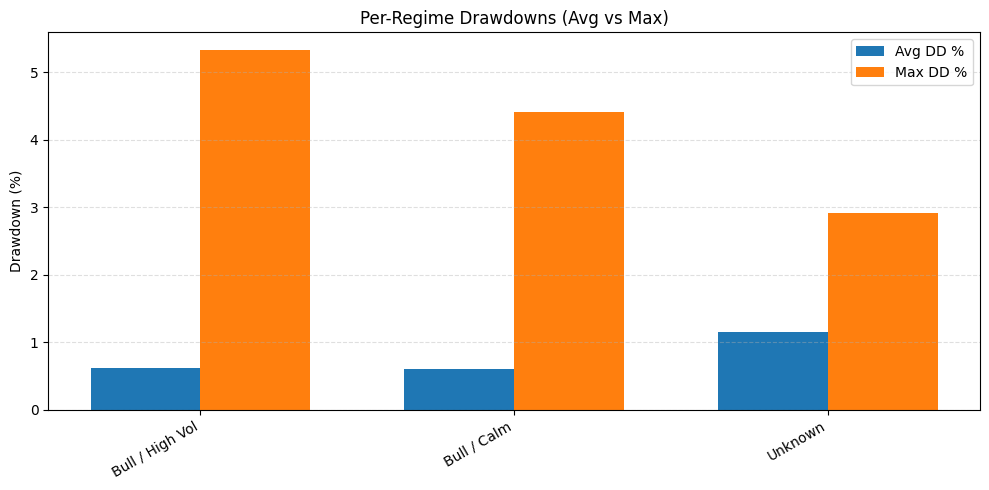

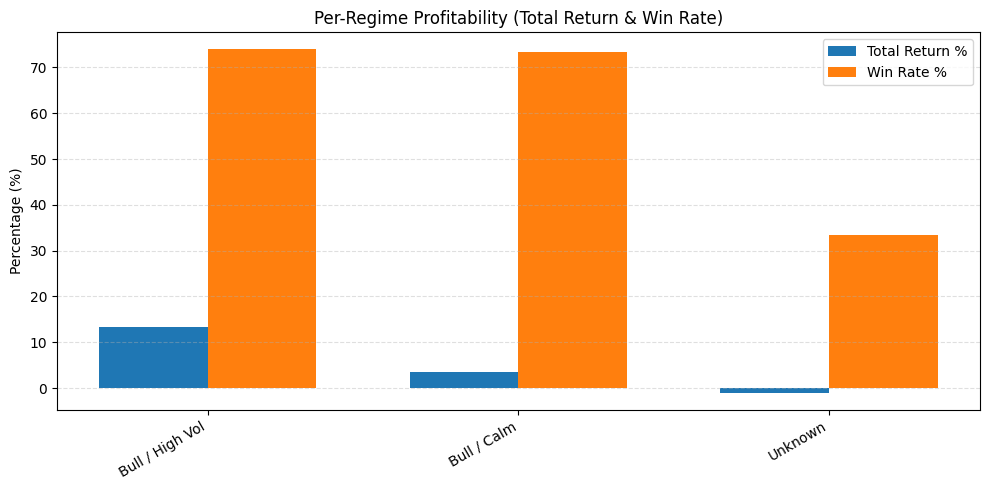

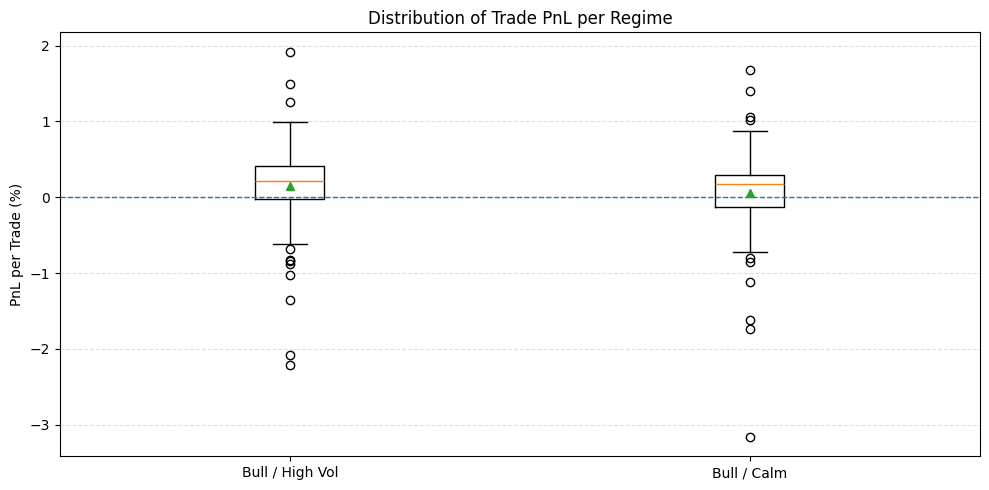

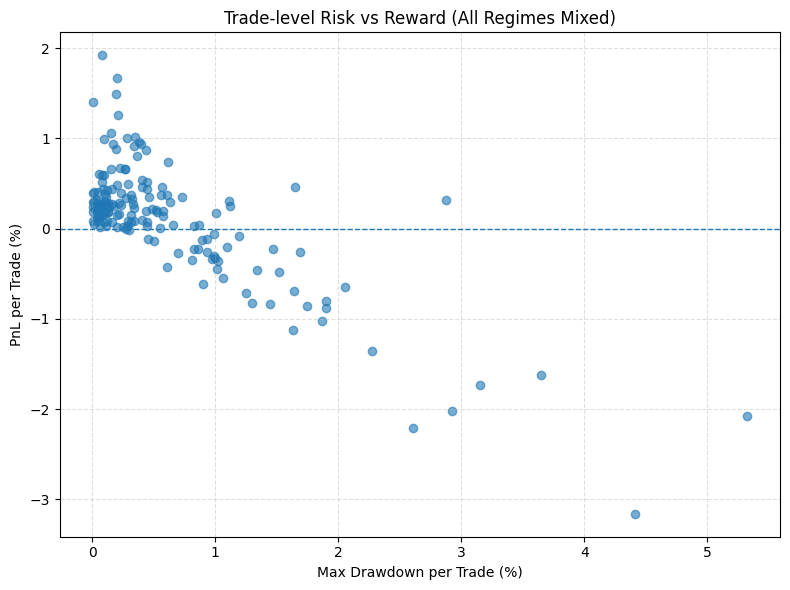

In [5]:
#===============================================================================
# CELL: Visualizing performance & drawdown per regime
#===============================================================================

import numpy as np
import matplotlib.pyplot as plt

# نتأكد إن عندنا بيانات ملخّصة per regime
print("\n=== Regime performance summary (regime_perf_df) ===")
print(regime_perf_df)

# نرتّبهم حسب أعلى Total Return
plot_df = regime_perf_df.sort_values("total_return_pct", ascending=False).reset_index(drop=True)
regimes = plot_df["regime_name"].values
x = np.arange(len(regimes))

#-------------------------------------------
# 1) Bar chart: Avg / Max Drawdown per Regime
#-------------------------------------------

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.35
ax.bar(x - width/2, plot_df["avg_dd_pct"], width, label="Avg DD %")
ax.bar(x + width/2, plot_df["max_dd_pct"], width, label="Max DD %")

ax.set_xticks(x)
ax.set_xticklabels(regimes, rotation=30, ha="right")
ax.set_ylabel("Drawdown (%)")
ax.set_title("Per-Regime Drawdowns (Avg vs Max)")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

#-------------------------------------------
# 2) Bar chart: Profit metrics per Regime
#    - Total Return %
#    - Win Rate %
#-------------------------------------------

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.35
ax.bar(x - width/2, plot_df["total_return_pct"], width, label="Total Return %")
ax.bar(x + width/2, plot_df["win_rate_pct"], width, label="Win Rate %")

ax.set_xticks(x)
ax.set_xticklabels(regimes, rotation=30, ha="right")
ax.set_ylabel("Percentage (%)")
ax.set_title("Per-Regime Profitability (Total Return & Win Rate)")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

#-------------------------------------------
# 3) Boxplot: توزيع PnL لكل صفقة في كل Regime
#-------------------------------------------

# هنشيل Unknown لأنها واحدة أو قليلة ومش مهمة أوي في الصورة الكبيرة
valid_trades = trades_with_regime.copy()
valid_trades = valid_trades[valid_trades["regime_name"].notna()]
valid_trades = valid_trades[valid_trades["regime_name"] != "Unknown"]

if not valid_trades.empty:
    # نضمن نفس ترتيب الregimes زي plot_df
    ordered_regimes = [r for r in regimes if r in valid_trades["regime_name"].unique()]
    data_per_regime = [
        valid_trades[valid_trades["regime_name"] == r]["pnl_pct"].values
        for r in ordered_regimes
    ]

    fig, ax = plt.subplots(figsize=(10, 5))

    bp = ax.boxplot(
        data_per_regime,
        labels=ordered_regimes,
        showmeans=True
    )

    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_ylabel("PnL per Trade (%)")
    ax.set_title("Distribution of Trade PnL per Regime")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No valid trades with regime_name for boxplot.")

#-------------------------------------------
# 4) Scatter: لكل صفقة → العلاقة بين Max DD و PnL
#    (Risk vs Reward per trade)
#-------------------------------------------

if not trades_with_regime.empty:
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(
        trades_with_regime["max_dd_pct"],
        trades_with_regime["pnl_pct"],
        alpha=0.6
    )

    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_xlabel("Max Drawdown per Trade (%)")
    ax.set_ylabel("PnL per Trade (%)")
    ax.set_title("Trade-level Risk vs Reward (All Regimes Mixed)")
    ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ trades_with_regime is empty – no trades to plot.")


In [6]:
#===============================================================================
# CELL: Detailed stats for the *current* regime (Bear / High Vol now)
#===============================================================================

import numpy as np

# نعيد حساب آخر window عشان نبقى متأكدين
if regime_df is None or regime_df.empty:
    print("⚠️ regime_df is empty. Run the regime clustering cell first.")
else:
    last_win = regime_df.sort_values("end_time").iloc[-1]
    current_regime = last_win["regime_name"]
    current_cluster = int(last_win["cluster"])

    print("=== Current Regime (from last window) ===")
    print(f"  Start:   {last_win['start_time']}")
    print(f"  End:     {last_win['end_time']}")
    print(f"  Cluster: {current_cluster}")
    print(f"  Regime:  {current_regime}")

    #-----------------------------
    # 1) فلتر كل الصفقات في نفس الـ regime
    #-----------------------------
    cur_trades = trades_with_regime[
        trades_with_regime["regime_name"] == current_regime
    ].copy()

    if cur_trades.empty:
        print(f"\n⚠️ No trades found in regime '{current_regime}'.")
    else:
        print(f"\nFound {len(cur_trades)} trades in regime '{current_regime}'.")

        #-----------------------------
        # 2) PnL overview
        #-----------------------------
        win_mask = cur_trades["pnl_pct"] > 0
        lose_mask = cur_trades["pnl_pct"] <= 0

        n_trades = len(cur_trades)
        n_wins   = win_mask.sum()
        n_losses = lose_mask.sum()

        win_rate = n_wins / n_trades * 100.0
        avg_pnl  = cur_trades["pnl_pct"].mean()
        median_pnl = cur_trades["pnl_pct"].median()
        worst_loss = cur_trades["pnl_pct"].min()
        best_win   = cur_trades["pnl_pct"].max()
        total_ret  = cur_trades["pnl_pct"].sum()

        print("\n=== PnL STATS (current regime only) ===")
        print(f"  #Trades:         {n_trades}")
        print(f"  Wins / Losses:   {n_wins} / {n_losses}")
        print(f"  Win Rate:        {win_rate:.2f}%")
        print(f"  Avg PnL/trade:   {avg_pnl:+.2f}%")
        print(f"  Median PnL:      {median_pnl:+.2f}%")
        print(f"  Best trade:      {best_win:+.2f}%")
        print(f"  Worst trade:     {worst_loss:+.2f}%")
        print(f"  Total Return:    {total_ret:+.2f}%")

        #-----------------------------
        # 3) Drawdown distribution (كل الصفقات)
        #-----------------------------
        dd_all = cur_trades["max_dd_pct"].values

        def safe_percentile(arr, q):
            return float(np.percentile(arr, q)) if len(arr) > 0 else 0.0

        dd_mean    = float(np.mean(dd_all))
        dd_median  = safe_percentile(dd_all, 50)
        dd_p75     = safe_percentile(dd_all, 75)
        dd_p90     = safe_percentile(dd_all, 90)
        dd_p95     = safe_percentile(dd_all, 95)
        dd_max     = float(np.max(dd_all))

        print("\n=== DRAWDOWN STATS (all trades, current regime) ===")
        print(f"  Mean DD:         {dd_mean:.2f}%")
        print(f"  Median DD:       {dd_median:.2f}%")
        print(f"  75th pct DD:     {dd_p75:.2f}%")
        print(f"  90th pct DD:     {dd_p90:.2f}%")
        print(f"  95th pct DD:     {dd_p95:.2f}%")
        print(f"  Worst DD (max):  {dd_max:.2f}%")

        #-----------------------------
        # 4) Drawdown conditional:
        #    - على الصفقات الكسبانة
        #    - على الصفقات الخسرانة
        #-----------------------------
        dd_wins = cur_trades.loc[win_mask, "max_dd_pct"].values
        dd_losses = cur_trades.loc[lose_mask, "max_dd_pct"].values

        if len(dd_wins) > 0:
            print("\n--- Drawdown on WINNING trades only ---")
            print(f"  Mean DD (wins):     {np.mean(dd_wins):.2f}%")
            print(f"  Median DD (wins):   {safe_percentile(dd_wins, 50):.2f}%")
            print(f"  75th pct DD (wins): {safe_percentile(dd_wins, 75):.2f}%")
            print(f"  90th pct DD (wins): {safe_percentile(dd_wins, 90):.2f}%")
        else:
            print("\n--- No winning trades in this regime to analyze DD for wins. ---")

        if len(dd_losses) > 0:
            print("\n--- Drawdown on LOSING trades only ---")
            print(f"  Mean DD (losses):     {np.mean(dd_losses):.2f}%")
            print(f"  Median DD (losses):   {safe_percentile(dd_losses, 50):.2f}%")
            print(f"  75th pct DD (losses): {safe_percentile(dd_losses, 75):.2f}%")
            print(f"  90th pct DD (losses): {safe_percentile(dd_losses, 90):.2f}%")
        else:
            print("\n--- No losing trades in this regime to analyze DD for losses. ---")

        #-----------------------------
        # 5) Holding time (bars_held)
        #-----------------------------
        bh = cur_trades["bars_held"].values
        bh_mean   = float(np.mean(bh))
        bh_median = safe_percentile(bh, 50)
        bh_p75    = safe_percentile(bh, 75)
        bh_p90    = safe_percentile(bh, 90)

        print("\n=== HOLDING TIME (bars_held, current regime) ===")
        print(f"  Mean bars held:   {bh_mean:.1f}")
        print(f"  Median bars held: {bh_median:.1f}")
        print(f"  75th pct:         {bh_p75:.1f}")
        print(f"  90th pct:         {bh_p90:.1f}")


=== Current Regime (from last window) ===
  Start:   2025-10-28 16:30:00-04:00
  End:     2025-11-12 13:45:00-05:00
  Cluster: 2
  Regime:  Bull / High Vol

Found 92 trades in regime 'Bull / High Vol'.

=== PnL STATS (current regime only) ===
  #Trades:         92
  Wins / Losses:   68 / 24
  Win Rate:        73.91%
  Avg PnL/trade:   +0.15%
  Median PnL:      +0.22%
  Best trade:      +1.92%
  Worst trade:     -2.21%
  Total Return:    +13.38%

=== DRAWDOWN STATS (all trades, current regime) ===
  Mean DD:         0.62%
  Median DD:       0.37%
  75th pct DD:     0.90%
  90th pct DD:     1.47%
  95th pct DD:     1.88%
  Worst DD (max):  5.32%

--- Drawdown on WINNING trades only ---
  Mean DD (wins):     0.35%
  Median DD (wins):   0.25%
  75th pct DD (wins): 0.45%
  90th pct DD (wins): 0.62%

--- Drawdown on LOSING trades only ---
  Mean DD (losses):     1.40%
  Median DD (losses):   1.02%
  75th pct DD (losses): 1.55%
  90th pct DD (losses): 2.16%

=== HOLDING TIME (bars_held, curre

In [7]:
#===============================================================================
# CELL: Signal Quality Map + Best Filters *inside current regime*
#===============================================================================

import numpy as np

#-----------------------------
# 0) Choose objective mode
#-----------------------------
# 1 = Default (avg_pnl - 0.3 * avg_dd)
# 2 = Total Return
# 3 = Only combos with win_rate >= 50%, sorted by avg_pnl
objective_mode = 1

# Minimum number of trades per combo to be considered
min_trades_per_combo = 10

#-----------------------------
# 1) Identify current regime again (from last window)
#-----------------------------
last_win = regime_df.sort_values("end_time").iloc[-1]
current_regime = last_win["regime_name"]
current_cluster = int(last_win["cluster"])

print("=== Current regime for Signal Quality Map ===")
print(f"  Start:   {last_win['start_time']}")
print(f"  End:     {last_win['end_time']}")
print(f"  Cluster: {current_cluster}")
print(f"  Regime:  {current_regime}")

#-----------------------------
# 2) Filter trades in this regime only
#-----------------------------
cur_trades = trades_with_regime[
    trades_with_regime["regime_name"] == current_regime
].copy()

print(f"\nTrades in current regime: {len(cur_trades)}")

rows = []
missing_entries = 0

for _, tr in cur_trades.iterrows():
    t = tr["entry_time"]

    # لو الـ index مش موجود بالضبط، نسيبه (أبسط حاجة)
    if t not in df_result.index:
        missing_entries += 1
        continue

    row = df_result.loc[t]

    rows.append({
        "entry_time": t,
        "pnl_pct": float(tr["pnl_pct"]),
        "max_dd_pct": float(tr["max_dd_pct"]),
        "bars_held": int(tr["bars_held"]),

        # features at entry:
        "pos_div_count": int(row.get("pos_div_count", 0)),
        "neg_div_count": int(row.get("neg_div_count", 0)),
        "rsi": float(row.get("rsi", np.nan)),
        "stoch": float(row.get("stoch", np.nan)),
        "macd_hist": float(row.get("macd_hist", np.nan)),
    })

sig_regime_df = pd.DataFrame(rows)

print(f"Built signal feature DF with {len(sig_regime_df)} rows (missing={missing_entries})")
if sig_regime_df.empty:
    raise ValueError("No matching entries between trades and df_result for current regime.")

print("\nSample of signal-regime features:")
print(sig_regime_df.head())

#-----------------------------
# 3) Build buckets (RSI / Stoch)
#-----------------------------

def rsi_bucket(r):
    if np.isnan(r):
        return "NA"
    if r < 30:  return "<30"
    if r < 40:  return "30-40"
    if r < 50:  return "40-50"
    if r < 60:  return "50-60"
    return ">=60"

def stoch_bucket(s):
    if np.isnan(s):
        return "NA"
    if s < 20:  return "<20"
    if s < 40:  return "20-40"
    if s < 60:  return "40-60"
    if s < 80:  return "60-80"
    return ">=80"

sig_regime_df["is_win"] = sig_regime_df["pnl_pct"] > 0
sig_regime_df["rsi_bucket"] = sig_regime_df["rsi"].apply(rsi_bucket)
sig_regime_df["stoch_bucket"] = sig_regime_df["stoch"].apply(stoch_bucket)

#-----------------------------
# 4) Group by (pos_div_count, rsi_bucket, stoch_bucket)
#-----------------------------

group_cols = ["pos_div_count", "rsi_bucket", "stoch_bucket"]

combo_stats = (
    sig_regime_df
    .groupby(group_cols)
    .agg(
        n_trades=("pnl_pct", "count"),
        win_rate=("is_win", "mean"),
        avg_pnl=("pnl_pct", "mean"),
        median_pnl=("pnl_pct", "median"),
        avg_dd=("max_dd_pct", "mean"),
        median_dd=("max_dd_pct", "median"),
        total_return=("pnl_pct", "sum"),
    )
    .reset_index()
)

combo_stats["win_rate"] = combo_stats["win_rate"] * 100.0
combo_stats["total_return_pct"] = combo_stats["total_return"]

# Filter combos with enough trades
combo_stats = combo_stats[combo_stats["n_trades"] >= min_trades_per_combo].copy()

if combo_stats.empty:
    print(f"\n⚠️ No combos with at least {min_trades_per_combo} trades.")
else:
    #-----------------------------
    # 5) Define objective score
    #-----------------------------
    if objective_mode == 1:
        # Default: profit - 0.3 * DD
        combo_stats["score"] = combo_stats["avg_pnl"] - 0.3 * combo_stats["avg_dd"]
        objective_name = "score = avg_pnl - 0.3 * avg_dd"
    elif objective_mode == 2:
        combo_stats["score"] = combo_stats["total_return_pct"]
        objective_name = "score = total_return_pct"
    else:
        # mode 3: only combos with win_rate >= 50%, score = avg_pnl
        combo_stats = combo_stats[combo_stats["win_rate"] >= 50.0].copy()
        combo_stats["score"] = combo_stats["avg_pnl"]
        objective_name = "score = avg_pnl (win_rate >= 50% only)"

    # Sort by score desc
    combo_stats_sorted = combo_stats.sort_values("score", ascending=False).reset_index(drop=True)

    print("\n===============================================")
    print(f"🏆 TOP SIGNAL COMBOS inside regime = '{current_regime}'")
    print(f"Objective: {objective_name}")
    print("===============================================\n")

    # Show top 15
    print(combo_stats_sorted.head(15))

    # # لو حابب تحفظها CSV
    out_name = f"signal_quality_combos_current_regime.replace(' ','_').csv"
    combo_stats_sorted.to_csv(out_name, index=False)
    print(f"\n📁 Full combo table saved to: {out_name}")


=== Current regime for Signal Quality Map ===
  Start:   2025-10-28 16:30:00-04:00
  End:     2025-11-12 13:45:00-05:00
  Cluster: 2
  Regime:  Bull / High Vol

Trades in current regime: 92
Built signal feature DF with 92 rows (missing=0)

Sample of signal-regime features:
                  entry_time   pnl_pct  max_dd_pct  bars_held  pos_div_count  \
0  2025-02-04 18:45:00-05:00  0.117889    0.041877          5              0   
1  2025-02-04 21:00:00-05:00  0.229582    0.020040          2              0   
2  2025-02-06 02:15:00-05:00 -0.126940    0.894178         59              0   
3  2025-02-07 12:45:00-05:00  0.350147    0.116133         26              0   
4  2025-02-18 22:45:00-05:00  0.292537    0.105136         20              0   

   neg_div_count        rsi      stoch  macd_hist  
0              0  42.631612  18.419090  -0.797085  
1              0  72.723446  47.082943   0.285031  
2              0  28.754213  14.720559  -1.014297  
3              0  31.796123  15.12687

In [8]:
#===============================================================================
# CELL: Simple Regime Cheat Sheet (what to expect per trade *now*)
#   - Uses real historical trades in current regime only
#===============================================================================

import numpy as np
import pandas as pd

# نفترض إن trades_with_regime و current_regime موجودين من الـ cells اللي فوق
current_regime_name = "Bull / Calm"  # أو خليها last_win["regime_name"] لو عندك

reg_trades = trades_with_regime[
    trades_with_regime["regime_name"] == current_regime_name
].copy()

print(f"=== Regime Cheat Sheet for '{current_regime_name}' ===")

n = len(reg_trades)
print(f"Number of trades in this regime: {n}")

if n == 0:
    print("⚠️ No trades in this regime yet. Nothing to analyse.")
else:
    # basic stats
    win_rate = (reg_trades["pnl_pct"] > 0).mean() * 100.0
    avg_pnl  = reg_trades["pnl_pct"].mean()
    med_pnl  = reg_trades["pnl_pct"].median()

    max_dd_series = reg_trades["max_dd_pct"]
    med_dd  = max_dd_series.median()
    q10_dd  = max_dd_series.quantile(0.10)
    q25_dd  = max_dd_series.quantile(0.25)
    q75_dd  = max_dd_series.quantile(0.75)
    q90_dd  = max_dd_series.quantile(0.90)

    # nicer summary
    print("\n--- PnL per trade (historical) ---")
    print(f"  Win rate:        {win_rate:.1f}%")
    print(f"  Avg PnL:         {avg_pnl:+.2f}%")
    print(f"  Median PnL:      {med_pnl:+.2f}%")

    print("\n--- Max Drawdown per trade (historical) ---")
    print(f"  10th pct DD:     {q10_dd:.2f}%")
    print(f"  25th pct DD:     {q25_dd:.2f}%")
    print(f"  Median DD:       {med_dd:.2f}%")
    print(f"  75th pct DD:     {q75_dd:.2f}%")
    print(f"  90th pct DD:     {q90_dd:.2f}%")

    # rough rules you can read directly
    print("\n--- Simple reading / rules of thumb ---")
    print(f"  • Typical (median) max DD per trade ≈ {med_dd:.2f}%")
    print(f"  • 75% of trades had max DD ≤ {q75_dd:.2f}%")
    print(f"  • 90% of trades had max DD ≤ {q90_dd:.2f}%")

    # optional: relation between DD and PnL
    corr = reg_trades[["pnl_pct", "max_dd_pct"]].corr().iloc[0,1]
    print(f"\n  Correlation between PnL and max DD: {corr:+.2f}")
    if corr > 0.2:
        print("    → Bigger winners tend to come with bigger drawdowns in this regime.")
    elif corr < -0.2:
        print("    → Bigger drawdowns usually end up as worse PnL (bad DD is bad sign).")
    else:
        print("    → No strong link between how deep DD is and final PnL.")


=== Regime Cheat Sheet for 'Bull / Calm' ===
Number of trades in this regime: 64

--- PnL per trade (historical) ---
  Win rate:        73.4%
  Avg PnL:         +0.05%
  Median PnL:      +0.17%

--- Max Drawdown per trade (historical) ---
  10th pct DD:     0.05%
  25th pct DD:     0.08%
  Median DD:       0.24%
  75th pct DD:     0.83%
  90th pct DD:     1.67%

--- Simple reading / rules of thumb ---
  • Typical (median) max DD per trade ≈ 0.24%
  • 75% of trades had max DD ≤ 0.83%
  • 90% of trades had max DD ≤ 1.67%

  Correlation between PnL and max DD: -0.87
    → Bigger drawdowns usually end up as worse PnL (bad DD is bad sign).
